In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from IPython import display
import matplotlib.animation as animation
from datetime import datetime

from utils import MyDataset
# from models import OneHiddenLayerTanhNetwork


# SGD endpoint as (tempered) posterior draws

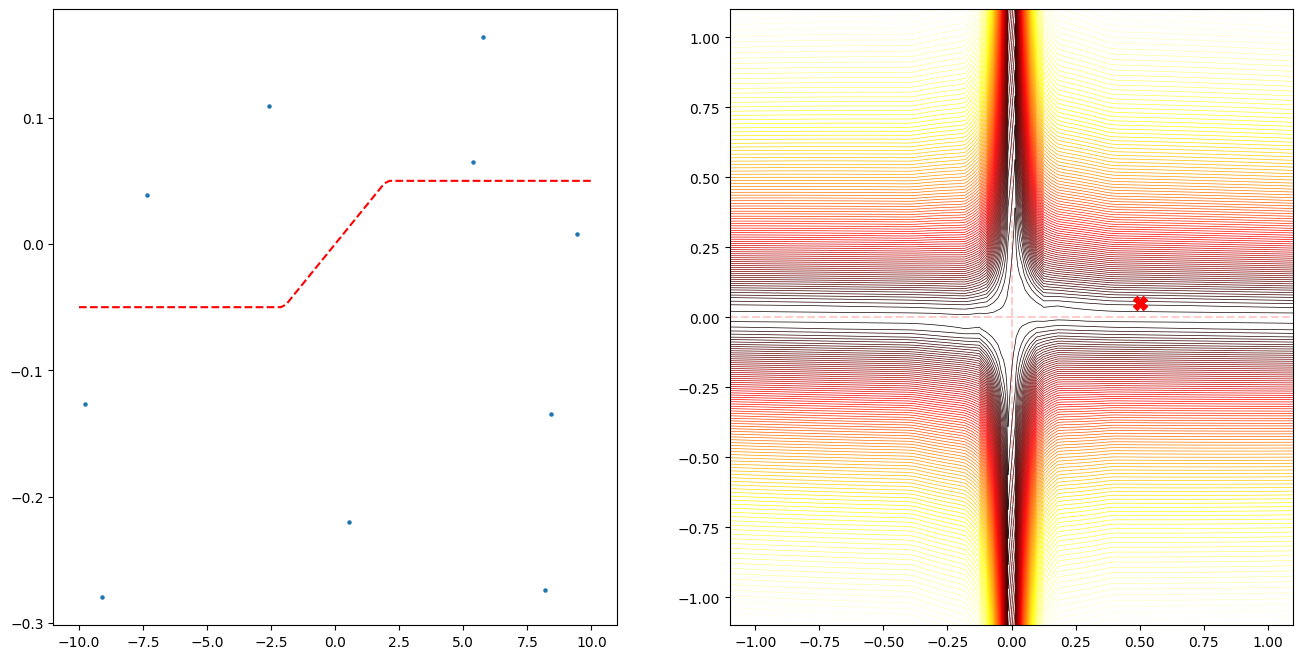

In [32]:
param_true = (0.5, 0.05)
activation = lambda x: torch.clip(x, min=-1, max=1)
# const_param_true = 0.5
regression_fn_true = OneHiddenLayerTanhNetwork(
    input_dim=1, 
    output_dim=1, 
    H=1, 
    init_param=param_true, 
    activation=activation
)
# print(regression_fn_true.state_dict())
def _generate_data(reg_func, n, xlims, sigma):
    X = torch.rand((n, 1)) * (xlims[1] - xlims[0]) + xlims[0]
    y = reg_func(X) + torch.randn_like(X) * sigma
    return X, y

n = 10
n_test = 100

xlims = (-10, 10)
sigma = 0.2
X_train, y_train = _generate_data(regression_fn_true, n, xlims, sigma)
X_test, y_test = _generate_data(regression_fn_true, n_test, xlims, sigma)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax = axes[0]
with torch.no_grad():
    ax.scatter(X_train, y_train, s=5)
#     plt.scatter(X_test, y_test)
    x = torch.linspace(xlims[0], xlims[1], steps=100).reshape(-1, 1)
    ax.plot(x, regression_fn_true(x), "r--")


ax = axes[1]
low, high = -1.1, 1.1
w1_axis = np.linspace(low, high, num=80)
w2_axis = np.linspace(low, high, num=80)
W1, W2 = np.meshgrid(w1_axis, w2_axis)
with torch.no_grad():
    num_rows, num_cols = W1.shape
    Z = np.zeros_like(W1)
    for i in range(num_rows):
        for j in range(num_cols):
            reg_func = OneHiddenLayerTanhNetwork(init_param=(W1[i, j], W2[i, j]), activation=activation)
            Z[i, j] = torch.mean((reg_func(X_train) - y_train)**2)
ax.contour(W1, W2, -np.log(Z), levels=100, alpha=1, linewidths=0.5, cmap="hot_r")
ax.plot([param_true[0]], [param_true[1]], "rX", markersize=10)
ax.vlines([0], ymin=low, ymax=high, linestyles="dashed", color="red", alpha=0.2)
ax.hlines([0], xmin=low, xmax=high, linestyles="dashed", color="red", alpha=0.2)



In [33]:
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)
ensemble_size = 500
ensemble_model = EnsembleModel(
    model_list=[
        OneHiddenLayerTanhNetwork(input_dim=1, output_dim=1, H=1, activation=activation) 
        for _ in range(ensemble_size)
    ], 
    loss_fn=nn.MSELoss(),
    learning_rate=0.01, 
    train_dataset=train_dataset, 
    test_dataset=test_dataset,
    optimiser_type="adam", 
#     batch_size=2, 
    batch_fraction=0.2, 
)
%time ensemble_model.train_ensemble(10)

CPU times: user 5.3 s, sys: 66.7 ms, total: 5.37 s
Wall time: 5.37 s


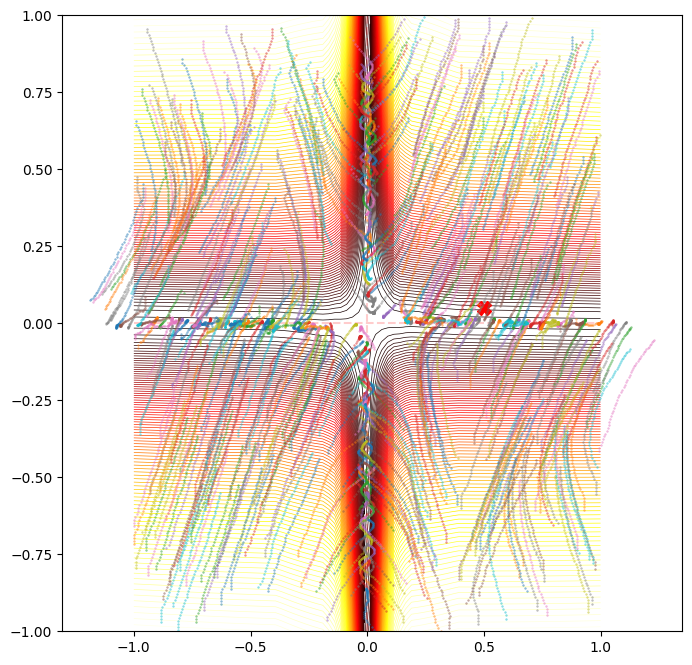

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
w1_axis = np.linspace(-1, 1, num=80)
w2_axis = np.linspace(-1, 1, num=80)
W1, W2 = np.meshgrid(w1_axis, w2_axis)
with torch.no_grad():
    num_rows, num_cols = W1.shape
    Z = np.zeros_like(W1)
    for i in range(num_rows):
        for j in range(num_cols):
            reg_func = OneHiddenLayerTanhNetwork(init_param=(W1[i, j], W2[i, j]), activation=activation)
            Z[i, j] = torch.mean((reg_func(X_train) - y_train)**2)
ax.contour(W1, W2, -np.log(Z), levels=100, alpha=1, linewidths=0.5, cmap="hot_r")
ax.plot([param_true[0]], [param_true[1]], "rX", markersize=10)
ax.vlines([0], ymin=-1, ymax=1, linestyles="dashed", color="red", alpha=0.2)
ax.hlines([0], xmin=-1, xmax=1, linestyles="dashed", color="red", alpha=0.2)


all_parameters = np.stack(
    [np.vstack([machine.history[j]["parameter"].detach() for j in range(0, machine.num_gradient_steps, 1)])
     for machine in ensemble_model.learning_machines], 
    axis=0
)

for i in range(ensemble_size):
    ax.plot(all_parameters[i, :, 0], all_parameters[i, :, 1], "+", markersize=1, alpha=0.5)

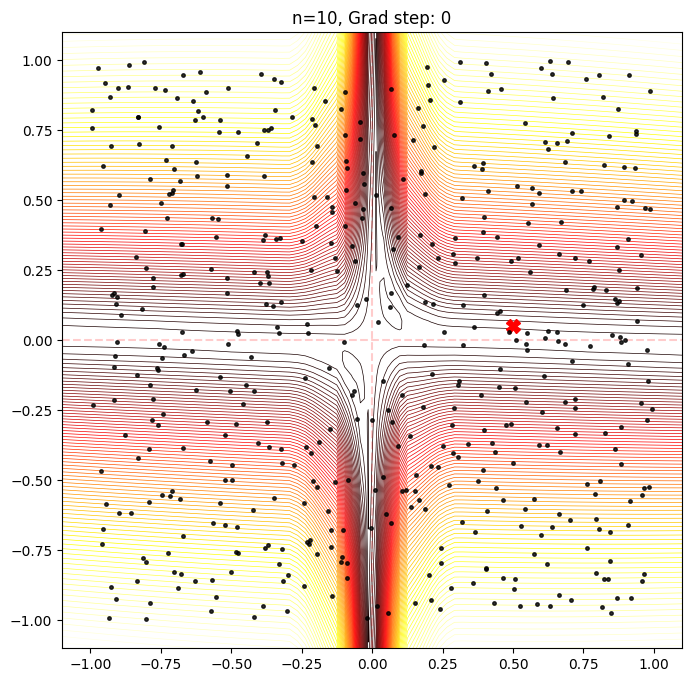

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

low, high = -1.1, 1.1
w1_axis = np.linspace(low, high, num=80)
w2_axis = np.linspace(low, high, num=80)
W1, W2 = np.meshgrid(w1_axis, w2_axis)
with torch.no_grad():
    num_rows, num_cols = W1.shape
    Z = np.zeros_like(W1)
    for i in range(num_rows):
        for j in range(num_cols):
            reg_func = OneHiddenLayerTanhNetwork(init_param=(W1[i, j], W2[i, j]), activation=activation)
            Z[i, j] = torch.mean((reg_func(X_train) - y_train)**2)
ax.contour(W1, W2, -np.log(Z), levels=100, alpha=1, linewidths=0.5, cmap="hot_r")
ax.plot([param_true[0]], [param_true[1]], "rX", markersize=10)
ax.vlines([0], ymin=low, ymax=high, linestyles="dashed", color="red", alpha=0.2)
ax.hlines([0], xmin=low, xmax=high, linestyles="dashed", color="red", alpha=0.2)

params = np.vstack([ensemble_model[i].history[0]["parameter"].detach() for i in range(ensemble_size)])
points, = ax.plot(params[:, 0], params[:, 1], ".", color="black", markersize=5, alpha=1)

def animation_frame(frame_num):
#     nonlocal ax, points
    params = all_parameters[:, frame_num, :]
    points.set_data(params[:, 0], params[:, 1])
    points.set_markersize(5)
    points.set_alpha(0.8)
    points.set_color("black")
    ax.set_title(f"n={n}, Grad step: {frame_num}")
    return points

anim = animation.FuncAnimation(
    fig, animation_frame, frames=range(0, ensemble_model[0].num_gradient_steps- 1, 1), interval=100, repeat=False
)
video = anim.to_html5_video()
display.display(display.HTML(video))

In [440]:
# anim.save("./anim.mp4", bitrate=400)

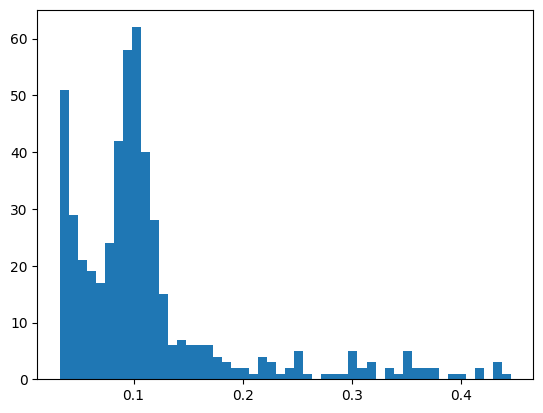

In [645]:
test_losses = [machine.snapshot(include_test_loss=True)["test_loss"] for machine in ensemble_model]
plt.hist(test_losses, bins=50);


# $n$ dependency

In [685]:
%%time
param_true = (0.5, 0.1)
activation = lambda x: torch.clip(x, min=-1, max=1)
regression_fn_true = OneHiddenLayerTanhNetwork(
    input_dim=1, 
    output_dim=1, 
    H=1, 
    init_param=param_true, 
    activation=activation
)
# n = 10
n_test = 100
xlims = (-10, 10)
sigma = 0.3
ensemble_size = 5
num_epoch = 30
num_repeat = 100

rec = {}
all_ns = list(range(2, 24 + 1, 2))
for n in all_ns:
    print(f"Processing n = {n}")
    for repeat_index in range(num_repeat):
        X_train, y_train = _generate_data(regression_fn_true, n, xlims, sigma)
        X_test, y_test = _generate_data(regression_fn_true, n_test, xlims, sigma)
        train_dataset = MyDataset(X_train, y_train)
        test_dataset = MyDataset(X_test, y_test)

        ensemble_model = EnsembleModel(
            model_list=[
                OneHiddenLayerTanhNetwork(input_dim=1, output_dim=1, H=1, activation=activation) 
                for _ in range(ensemble_size)
            ], 
            loss_fn=nn.MSELoss(),
            learning_rate=0.01, 
            train_dataset=train_dataset, 
            test_dataset=test_dataset,
            optimiser_type="adam", 
    #         batch_size=2, 
            batch_fraction=0.2, 
        )
        ensemble_model.train_ensemble(num_epoch)
        
        all_parameters = np.stack(
            [np.vstack([machine.history[j]["parameter"].detach() for j in range(0, machine.num_gradient_steps, 1)])
             for machine in ensemble_model.learning_machines], 
            axis=0
        )

        if n not in rec:
            rec[n] = []
        rec[n].append(ensemble_model)
#         rec[n].append(all_parameters)

Processing n = 26
Processing n = 28
Processing n = 30
Processing n = 32
Processing n = 34
Processing n = 36
Processing n = 38
CPU times: user 2min 27s, sys: 4.98 s, total: 2min 32s
Wall time: 2min 35s


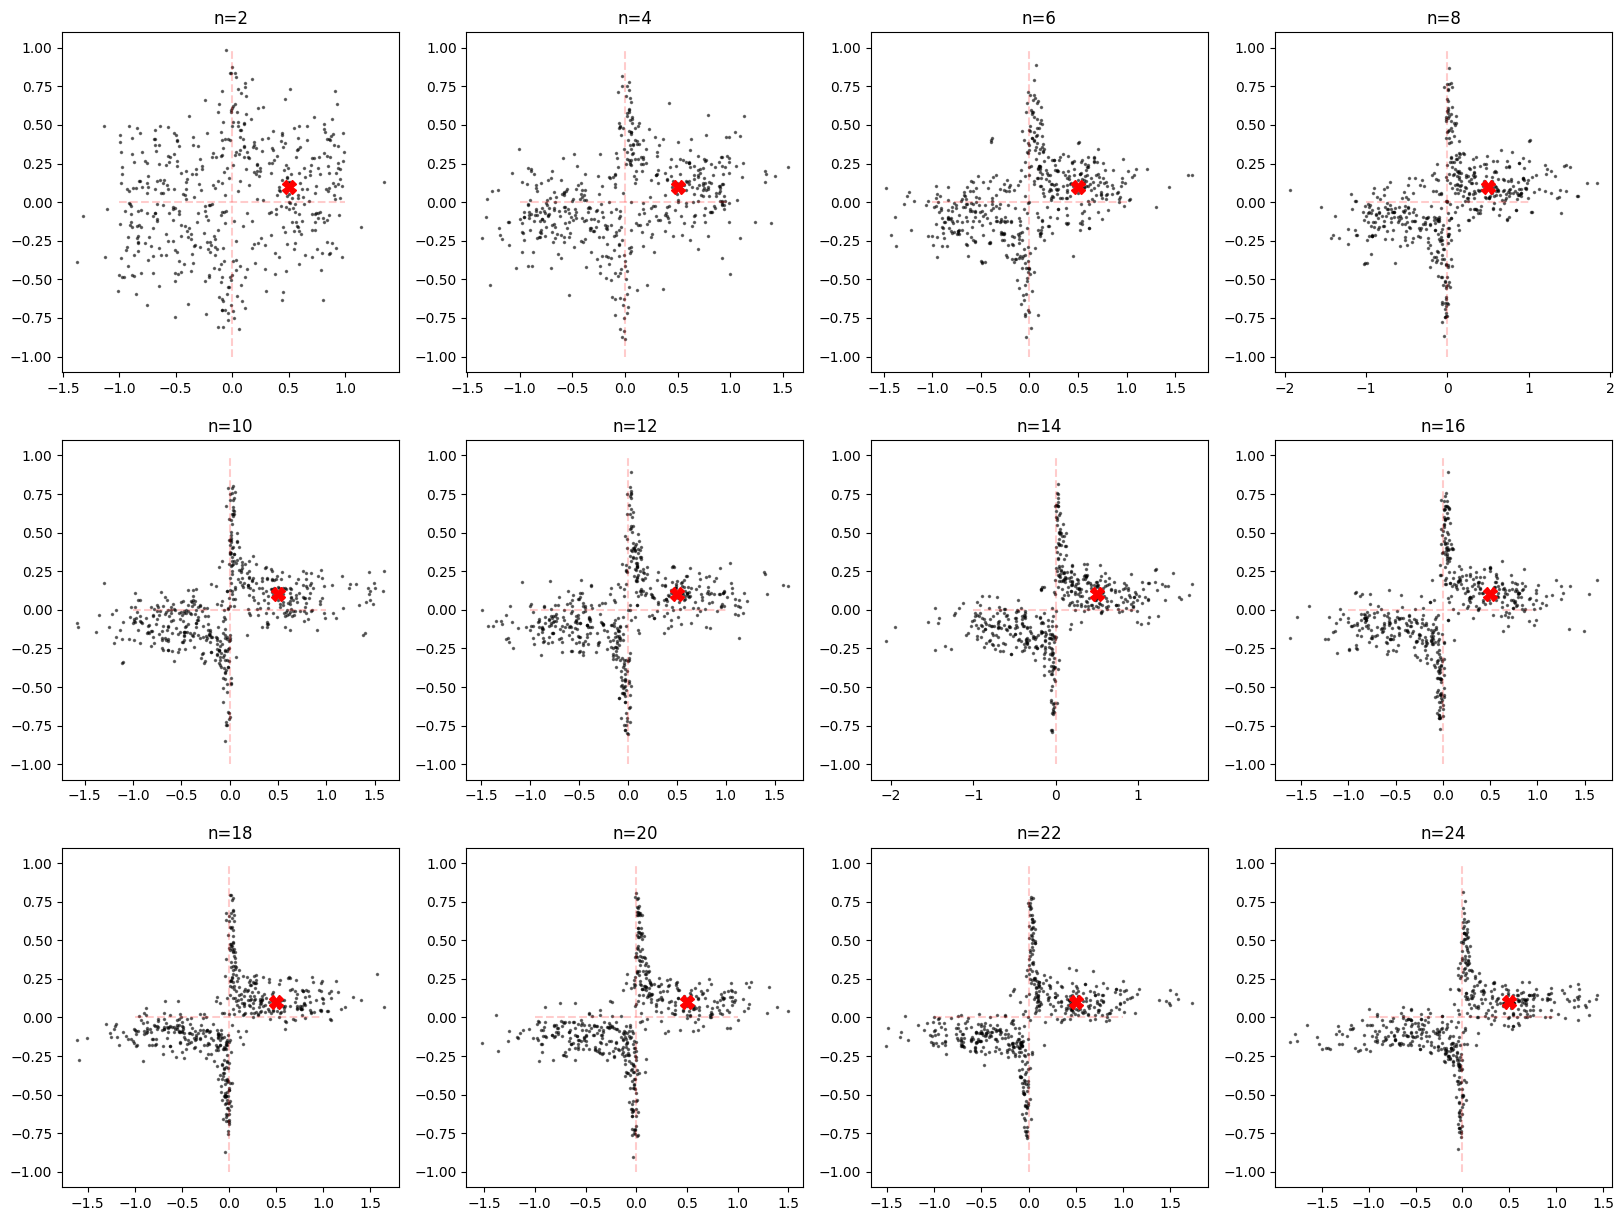

In [678]:
num_col = 4
num_row = len(rec) // num_col + (len(rec) % num_col != 0)
fig, axes = plt.subplots(num_row, num_col, figsize=(5 * num_col, 5 * num_row))
axes = np.ravel(axes)
c = 0
for n in sorted(rec.keys()):
    ax = axes[c]
    c += 1
    for ensemble_model in rec[n]:
        all_parameters = np.stack(
            [np.vstack([machine.history[j]["parameter"].detach() for j in range(0, machine.num_gradient_steps, 1)])
             for machine in ensemble_model.learning_machines], 
            axis=0
        )
#     for all_parameters in rec[n]:
        for i in range(ensemble_size):
            ax.plot(all_parameters[i, -1, 0], all_parameters[i, -1, 1], ".", color="black", markersize=3, alpha=0.5)
    
    ax.plot([param_true[0]], [param_true[1]], "rX", markersize=10)
    ax.vlines([0], ymin=-1, ymax=1, linestyles="dashed", color="red", alpha=0.2)
    ax.hlines([0], xmin=-1, xmax=1, linestyles="dashed", color="red", alpha=0.2)

    ax.set_title(f"n={n}")
# fig.savefig("sgd_endpoints_distributions.png")

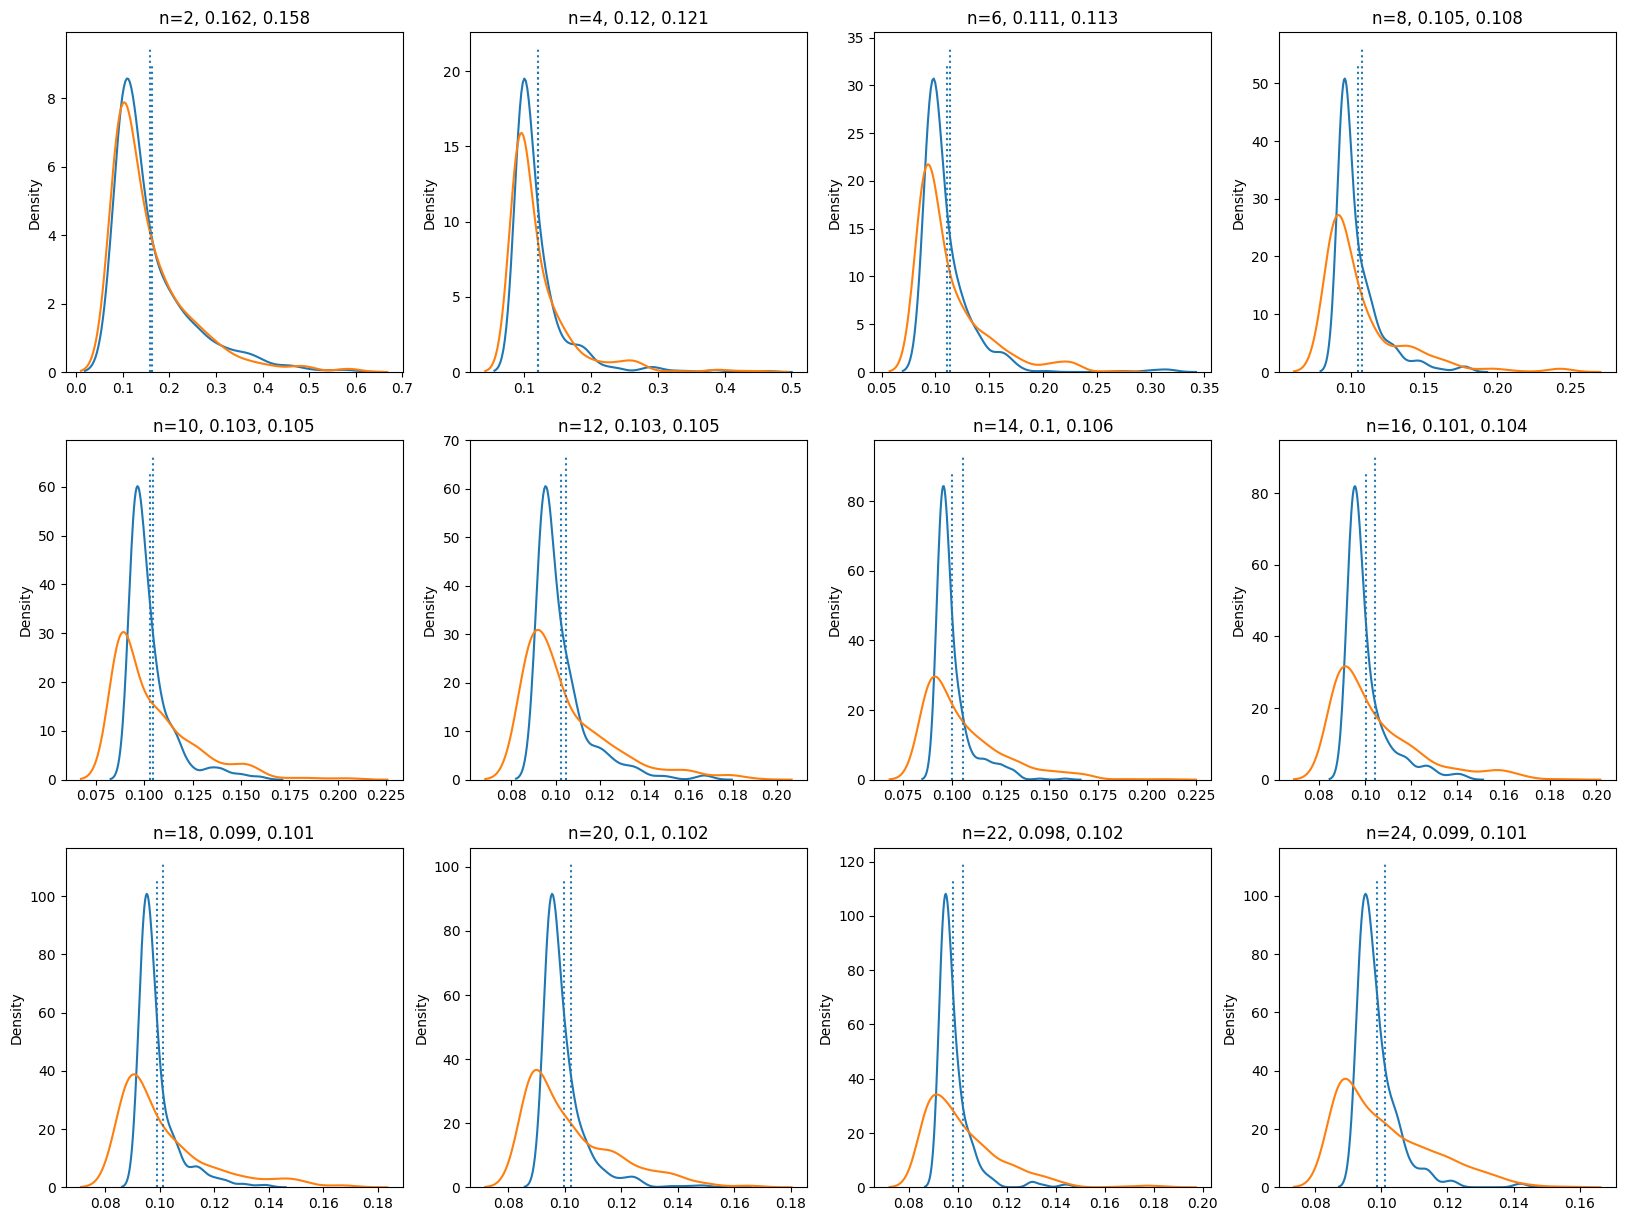

In [679]:
num_col = 4
num_row = len(rec) // num_col + (len(rec) % num_col != 0)
fig, axes = plt.subplots(num_row, num_col, figsize=(5 * num_col, 5 * num_row))
axes = np.ravel(axes)


dataset1 = MyDataset(*_generate_data(regression_fn_true, 1000, xlims, sigma))
dataset2 = MyDataset(*_generate_data(lambda x: 0, 1000, xlims, sigma))

c = 0
for n in sorted(rec.keys()):
    ax = axes[c]
    c += 1
    titlestr = f"n={n}"
    for dset in [dataset1, dataset2]:
        test_losses = []
        for ensemble_model in rec[n]:
            test_losses += [machine.compute_loss(dset) for machine in ensemble_model]
        sns.kdeplot(test_losses, ax=ax)
        mean = np.mean(test_losses)
        ymin, ymax = ax.get_ylim()
        ax.vlines([mean], ymin=ymin, ymax=ymax, linestyle="dotted")
#         ax.hist(test_losses, alpha=0.5)
        titlestr += f", {np.around(mean, 3)}"
#     ax.set_yscale('log')
    ax.set_title(titlestr)
# fig.savefig("sgd_endpoint_test_loss_distribution.png")

AttributeError: 'list' object has no attribute 'learning_machines'

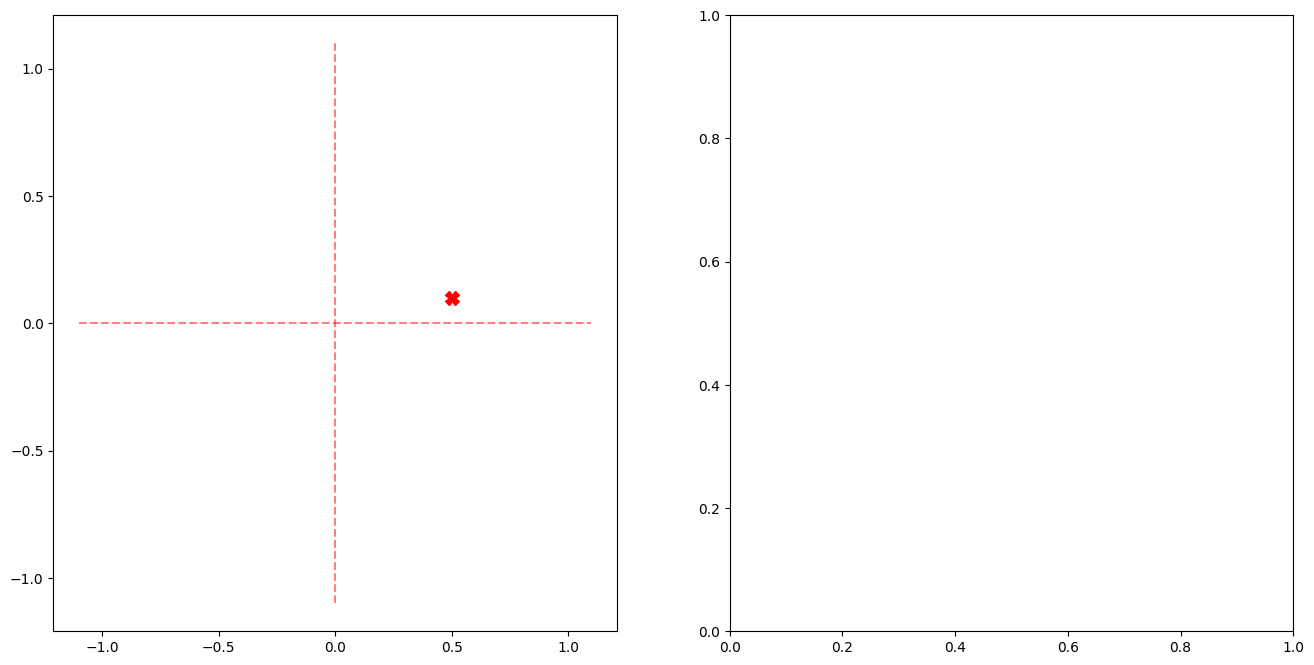

In [683]:
dataset1 = MyDataset(*_generate_data(regression_fn_true, 1000, xlims, sigma))
dataset2 = MyDataset(*_generate_data(lambda x: 0, 1000, xlims, sigma))


fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax = axes[0]
low, high = -1.1, 1.1
ax.plot([param_true[0]], [param_true[1]], "rX", markersize=10)
ax.vlines([0], ymin=low, ymax=high, linestyles="dashed", color="red", alpha=0.5)
ax.hlines([0], xmin=low, xmax=high, linestyles="dashed", color="red", alpha=0.5)

all_ns = sorted(rec.keys())
all_parameters = np.stack([
    np.stack([np.vstack([machine.history[j]["parameter"].detach() for j in range(0, machine.num_gradient_steps, 1)])
              for machine in ensemble_model.learning_machines], axis=0) 
    for ensemble_model in rec.values()], axis=0)

points, = ax.plot(
    all_parameters[:, :, -1, 0].ravel(), 
    all_parameters[:, :, -1, 1].ravel(),
    "b+", 
    markersize=10,  
    alpha=0.5
);


ax = axes[1]
for dset in [dataset1, dataset2]:
    test_losses = []
    for ensemble_model in rec[n]:
        test_losses += [machine.compute_loss(dset) for machine in ensemble_model]
    sns.kdeplot(test_losses, ax=ax)
    mean = np.mean(test_losses)
    ymin, ymax = ax.get_ylim()
    ax.vlines([mean], ymin=ymin, ymax=ymax, linestyle="dotted")
#         ax.hist(test_losses, alpha=0.5)
    titlestr += f", {np.around(mean, 3)}"
#     ax.set_yscale('log')
ax.set_title(titlestr)



def animation_frame(frame_num):
    n = all_ns[frame_num]
    all_parameters = np.stack(rec[n], axis=0)
    points.set_data(
        all_parameters[:, :, -1, 0].ravel(), 
        all_parameters[:, :, -1, 1].ravel()
    )
    points.set_markersize(5)
    points.set_alpha(0.5)
    points.set_color("black")
    ax.set_title(f"n={n}")
    return points

anim = animation.FuncAnimation(
    fig, 
    animation_frame, 
    frames=range(0, len(rec), 1), 
    interval=200, 
    repeat=False
)
video = anim.to_html5_video()
display.display(display.HTML(video))

In [538]:
datestring = datetime.today().strftime('%Y%m%d')
# anim.save(f"./sgd_endpoints_distributions_{datestring}_sigma{sigma}_epoch{num_epoch}.mp4", bitrate=400)

# SGLD

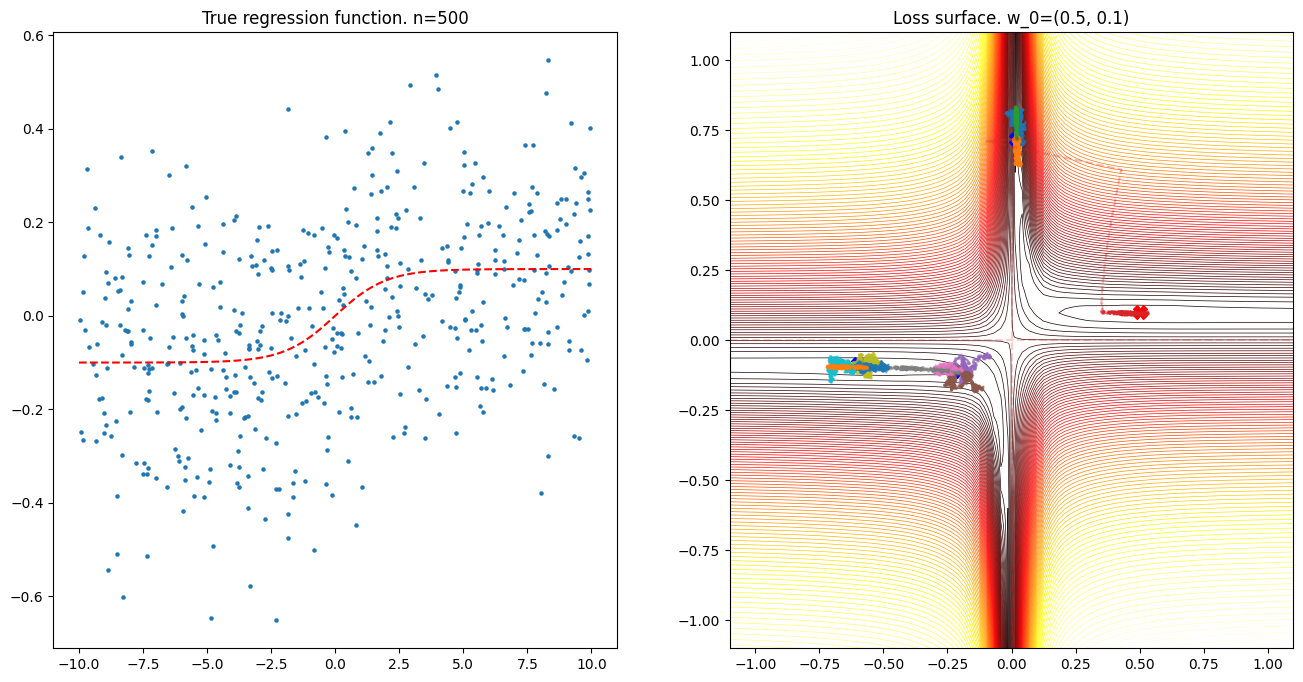

In [73]:
import copy

param_true = (0.5, 0.1)
# activation = lambda x: torch.clip(x, min=-1, max=1)
# const_param_true = 0.5
regression_fn_true = OneHiddenLayerTanhNetwork(
    input_dim=1, 
    output_dim=1, 
    H=1, 
    init_param=param_true, 
#     activation=activation
)

n = 500
n_test = 100

xlims = (-10, 10)
sigma = 0.2
X_train, y_train = _generate_data(regression_fn_true, n, xlims, sigma)
X_test, y_test = _generate_data(regression_fn_true, n_test, xlims, sigma)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax = axes[0]
with torch.no_grad():
    ax.scatter(X_train, y_train, s=5)
#     plt.scatter(X_test, y_test)
    x = torch.linspace(xlims[0], xlims[1], steps=100).reshape(-1, 1)
    ax.plot(x, regression_fn_true(x), "r--")
ax.set_title(f"True regression function. n={n}")

ax = axes[1]
low, high = -1.1, 1.1
w1_axis = np.linspace(low, high, num=80)
w2_axis = np.linspace(low, high, num=80)
W1, W2 = np.meshgrid(w1_axis, w2_axis)
with torch.no_grad():
    num_rows, num_cols = W1.shape
    Z = np.zeros_like(W1)
    for i in range(num_rows):
        for j in range(num_cols):
            reg_func = OneHiddenLayerTanhNetwork(init_param=(W1[i, j], W2[i, j]), activation=activation)
            Z[i, j] = torch.mean((reg_func(X_train) - y_train)**2)
ax.contour(W1, W2, -np.log(Z), levels=100, alpha=1, linewidths=0.5, cmap="hot_r")
ax.plot([param_true[0]], [param_true[1]], "rX", markersize=10)
ax.vlines([0], ymin=low, ymax=high, linestyles="dashed", color="red", alpha=0.2)
ax.hlines([0], xmin=low, xmax=high, linestyles="dashed", color="red", alpha=0.2)
ax.set_title(f"Loss surface. w_0={param_true}");

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

loss_fn = nn.MSELoss()

for _ in range(3):
    model = OneHiddenLayerTanhNetwork(H=1)
    machine = LearningMachine(
        model, 
        train_dataset,
        test_dataset, 
        loss_fn, 
        OPTIMISER_SWITCH["sgd"](model.parameters(), lr=0.001), 
    #     batch_size=batch_size,
        batch_fraction=0.2,
    )
    early_stopping = EarlyStopping(patience=5, epsilon=1e-3)
    machine.training_loop(500, stopping_condition=early_stopping.early_stopping_by_train_loss_improvement)
    param_final = machine.history[max(machine.history.keys())]["parameter"].detach()
    ax.plot([param_final[0]], [param_final[1]], "bX", markersize=10)
    for inv_temp in [1e-3, 1e-2, 1e-1, 1]:
        sgld = TrainOptimizerSGLD(copy.deepcopy(machine.model), alpha=0.002)
        sgld.fit(train_dataset, num_steps=2000, inverse_temp=inv_temp)
        w1, w2 = [sgld.parameter_trace[f"fc_{i}.weight"].flatten() for i in [1, 2]]
        ax.plot(w1, w2, "+--", markersize=2, alpha=0.3)
a = 0.2
# ax.set_xlim([param_final[0] - a, param_final[0] + a])
# ax.set_ylim([param_final[1] - a, param_final[1] + a])

In [77]:
model.state_dict()

OrderedDict([('fc_1.weight', tensor([[-0.6005]])),
             ('fc_2.weight', tensor([[-0.0864]]))])

In [87]:
new_model = copy.deepcopy(model)
new_state = {
    key: val[0] for key, val in sgld.parameter_trace.items()
}
new_model.load_state_dict(new_state)

<All keys matched successfully>

In [89]:
new_state

{'fc_1.weight': tensor([[-0.6023]]), 'fc_2.weight': tensor([[-0.0892]])}